<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:10:56] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


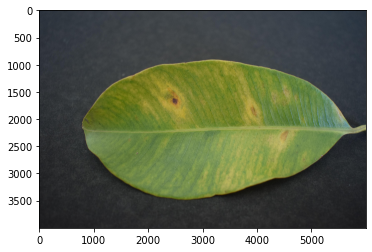

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

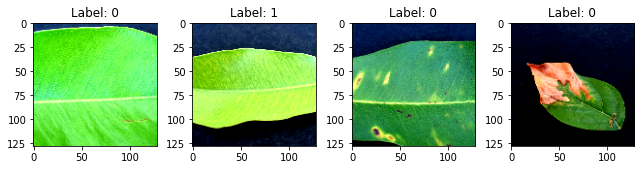

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:11:02] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:11:04] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.267466038096621 samples/sec                   batch loss = 0.6360898017883301 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.2758963042831677 samples/sec                   batch loss = 0.7023720741271973 | accuracy = 0.65


Epoch[1] Batch[15] Speed: 1.2715996346159268 samples/sec                   batch loss = 0.5245745778083801 | accuracy = 0.6


Epoch[1] Batch[20] Speed: 1.2670081208458102 samples/sec                   batch loss = 0.37287214398384094 | accuracy = 0.625


Epoch[1] Batch[25] Speed: 1.2669983611624578 samples/sec                   batch loss = 0.62986159324646 | accuracy = 0.64


Epoch[1] Batch[30] Speed: 1.2692093193276524 samples/sec                   batch loss = 0.29216325283050537 | accuracy = 0.6416666666666667


Epoch[1] Batch[35] Speed: 1.2573697051773183 samples/sec                   batch loss = 0.2103196382522583 | accuracy = 0.6428571428571429


Epoch[1] Batch[40] Speed: 1.2616332032738122 samples/sec                   batch loss = 0.49962809681892395 | accuracy = 0.6625


Epoch[1] Batch[45] Speed: 1.2617411789054813 samples/sec                   batch loss = 0.8181360363960266 | accuracy = 0.65


Epoch[1] Batch[50] Speed: 1.2613374560902035 samples/sec                   batch loss = 0.7163235545158386 | accuracy = 0.67


Epoch[1] Batch[55] Speed: 1.2695968648618297 samples/sec                   batch loss = 0.8160552978515625 | accuracy = 0.6727272727272727


Epoch[1] Batch[60] Speed: 1.2617659456936972 samples/sec                   batch loss = 0.5383284091949463 | accuracy = 0.6583333333333333


Epoch[1] Batch[65] Speed: 1.266666812631836 samples/sec                   batch loss = 0.41247329115867615 | accuracy = 0.6615384615384615


Epoch[1] Batch[70] Speed: 1.268705048211986 samples/sec                   batch loss = 1.251970648765564 | accuracy = 0.65


Epoch[1] Batch[75] Speed: 1.2697261953999979 samples/sec                   batch loss = 0.3161885142326355 | accuracy = 0.6666666666666666


Epoch[1] Batch[80] Speed: 1.2685597151845256 samples/sec                   batch loss = 1.2743728160858154 | accuracy = 0.6625


Epoch[1] Batch[85] Speed: 1.2731720669477875 samples/sec                   batch loss = 0.4259379804134369 | accuracy = 0.6588235294117647


Epoch[1] Batch[90] Speed: 1.2697820289821726 samples/sec                   batch loss = 0.6417502164840698 | accuracy = 0.6555555555555556


Epoch[1] Batch[95] Speed: 1.2666927295325339 samples/sec                   batch loss = 0.8823166489601135 | accuracy = 0.6526315789473685


Epoch[1] Batch[100] Speed: 1.2657906615774142 samples/sec                   batch loss = 0.9025434255599976 | accuracy = 0.6425


Epoch[1] Batch[105] Speed: 1.2745446393313775 samples/sec                   batch loss = 1.0759146213531494 | accuracy = 0.6404761904761904


Epoch[1] Batch[110] Speed: 1.2696459612428854 samples/sec                   batch loss = 0.4642874598503113 | accuracy = 0.6454545454545455


Epoch[1] Batch[115] Speed: 1.261711289248985 samples/sec                   batch loss = 0.4500989019870758 | accuracy = 0.6391304347826087


Epoch[1] Batch[120] Speed: 1.2761551386698857 samples/sec                   batch loss = 0.5156862735748291 | accuracy = 0.6416666666666667


Epoch[1] Batch[125] Speed: 1.2643828384678835 samples/sec                   batch loss = 0.38987958431243896 | accuracy = 0.644


Epoch[1] Batch[130] Speed: 1.2713784840547002 samples/sec                   batch loss = 0.3386683464050293 | accuracy = 0.6519230769230769


Epoch[1] Batch[135] Speed: 1.2688945587685294 samples/sec                   batch loss = 1.4520143270492554 | accuracy = 0.6462962962962963


Epoch[1] Batch[140] Speed: 1.2646364501568395 samples/sec                   batch loss = 0.4023119807243347 | accuracy = 0.6392857142857142


Epoch[1] Batch[145] Speed: 1.2685227876746872 samples/sec                   batch loss = 0.2754754424095154 | accuracy = 0.6396551724137931


Epoch[1] Batch[150] Speed: 1.2702214693510492 samples/sec                   batch loss = 0.4022921919822693 | accuracy = 0.6416666666666667


Epoch[1] Batch[155] Speed: 1.2704786796400178 samples/sec                   batch loss = 0.44101735949516296 | accuracy = 0.646774193548387


Epoch[1] Batch[160] Speed: 1.2689017564877505 samples/sec                   batch loss = 0.750721275806427 | accuracy = 0.6421875


Epoch[1] Batch[165] Speed: 1.274736576574386 samples/sec                   batch loss = 0.33014002442359924 | accuracy = 0.6424242424242425


Epoch[1] Batch[170] Speed: 1.2752049445421825 samples/sec                   batch loss = 0.47397711873054504 | accuracy = 0.6411764705882353


Epoch[1] Batch[175] Speed: 1.2707848898751857 samples/sec                   batch loss = 0.3228309154510498 | accuracy = 0.6442857142857142


Epoch[1] Batch[180] Speed: 1.2734888568313179 samples/sec                   batch loss = 0.5108885765075684 | accuracy = 0.6416666666666667


Epoch[1] Batch[185] Speed: 1.2708991550678506 samples/sec                   batch loss = 0.5292346477508545 | accuracy = 0.6418918918918919


Epoch[1] Batch[190] Speed: 1.2659217968146597 samples/sec                   batch loss = 0.5117455720901489 | accuracy = 0.6394736842105263


Epoch[1] Batch[195] Speed: 1.2723174823893568 samples/sec                   batch loss = 0.5752415657043457 | accuracy = 0.6410256410256411


Epoch[1] Batch[200] Speed: 1.271818355414566 samples/sec                   batch loss = 0.43789535760879517 | accuracy = 0.64625


Epoch[1] Batch[205] Speed: 1.2708085690949424 samples/sec                   batch loss = 0.3914797306060791 | accuracy = 0.6463414634146342


Epoch[1] Batch[210] Speed: 1.2701305953313213 samples/sec                   batch loss = 1.1288847923278809 | accuracy = 0.6464285714285715


Epoch[1] Batch[215] Speed: 1.273481993635177 samples/sec                   batch loss = 0.4091634154319763 | accuracy = 0.6476744186046511


Epoch[1] Batch[220] Speed: 1.27101247791363 samples/sec                   batch loss = 1.1998112201690674 | accuracy = 0.65


Epoch[1] Batch[225] Speed: 1.2683422095481194 samples/sec                   batch loss = 0.5416633486747742 | accuracy = 0.6488888888888888


Epoch[1] Batch[230] Speed: 1.269667580227284 samples/sec                   batch loss = 0.6264917850494385 | accuracy = 0.6478260869565218


Epoch[1] Batch[235] Speed: 1.2705429503797911 samples/sec                   batch loss = 0.8495946526527405 | accuracy = 0.6468085106382979


Epoch[1] Batch[240] Speed: 1.2699991635387684 samples/sec                   batch loss = 0.5281181335449219 | accuracy = 0.653125


Epoch[1] Batch[245] Speed: 1.2643785505315341 samples/sec                   batch loss = 0.5132501125335693 | accuracy = 0.6530612244897959


Epoch[1] Batch[250] Speed: 1.262731563976434 samples/sec                   batch loss = 0.19892185926437378 | accuracy = 0.657


Epoch[1] Batch[255] Speed: 1.265012718578897 samples/sec                   batch loss = 0.891985297203064 | accuracy = 0.657843137254902


Epoch[1] Batch[260] Speed: 1.2634755877924992 samples/sec                   batch loss = 0.46057435870170593 | accuracy = 0.6586538461538461


Epoch[1] Batch[265] Speed: 1.2731692650560553 samples/sec                   batch loss = 0.3556835949420929 | accuracy = 0.659433962264151


Epoch[1] Batch[270] Speed: 1.2720808425514472 samples/sec                   batch loss = 0.6481049656867981 | accuracy = 0.6601851851851852


Epoch[1] Batch[275] Speed: 1.272804737864926 samples/sec                   batch loss = 0.41656187176704407 | accuracy = 0.6609090909090909


Epoch[1] Batch[280] Speed: 1.2837346932466798 samples/sec                   batch loss = 0.2475721538066864 | accuracy = 0.6651785714285714


Epoch[1] Batch[285] Speed: 1.2721264658041462 samples/sec                   batch loss = 0.428159236907959 | accuracy = 0.6675438596491228


Epoch[1] Batch[290] Speed: 1.2703524662140342 samples/sec                   batch loss = 0.839608371257782 | accuracy = 0.6689655172413793


Epoch[1] Batch[295] Speed: 1.2720913558649656 samples/sec                   batch loss = 0.5396922826766968 | accuracy = 0.6694915254237288


Epoch[1] Batch[300] Speed: 1.2667018150439837 samples/sec                   batch loss = 0.8274444341659546 | accuracy = 0.6658333333333334


Epoch[1] Batch[305] Speed: 1.2696704628141642 samples/sec                   batch loss = 0.44507837295532227 | accuracy = 0.6688524590163935


Epoch[1] Batch[310] Speed: 1.272079202876013 samples/sec                   batch loss = 0.4488673508167267 | accuracy = 0.667741935483871


Epoch[1] Batch[315] Speed: 1.2716796339380447 samples/sec                   batch loss = 0.805799663066864 | accuracy = 0.6682539682539682


Epoch[1] Batch[320] Speed: 1.2724695648797157 samples/sec                   batch loss = 0.6042524576187134 | accuracy = 0.66953125


Epoch[1] Batch[325] Speed: 1.264689262981423 samples/sec                   batch loss = 0.8662300109863281 | accuracy = 0.67


Epoch[1] Batch[330] Speed: 1.2684371433109873 samples/sec                   batch loss = 0.18771758675575256 | accuracy = 0.671969696969697


Epoch[1] Batch[335] Speed: 1.2604313494097303 samples/sec                   batch loss = 0.3956255316734314 | accuracy = 0.6708955223880597


Epoch[1] Batch[340] Speed: 1.270912922185633 samples/sec                   batch loss = 0.17526298761367798 | accuracy = 0.6735294117647059


Epoch[1] Batch[345] Speed: 1.2712560411731018 samples/sec                   batch loss = 0.36969274282455444 | accuracy = 0.6746376811594202


Epoch[1] Batch[350] Speed: 1.2678608552528416 samples/sec                   batch loss = 0.6463008522987366 | accuracy = 0.6728571428571428


Epoch[1] Batch[355] Speed: 1.2727924746819823 samples/sec                   batch loss = 0.4477614462375641 | accuracy = 0.6753521126760563


Epoch[1] Batch[360] Speed: 1.2751297344386696 samples/sec                   batch loss = 1.4096980094909668 | accuracy = 0.6763888888888889


Epoch[1] Batch[365] Speed: 1.2704525113812588 samples/sec                   batch loss = 0.7165577411651611 | accuracy = 0.6767123287671233


Epoch[1] Batch[370] Speed: 1.2732632800894983 samples/sec                   batch loss = 0.5745047926902771 | accuracy = 0.6763513513513514


Epoch[1] Batch[375] Speed: 1.2673318064914925 samples/sec                   batch loss = 0.46496620774269104 | accuracy = 0.6773333333333333


Epoch[1] Batch[380] Speed: 1.266461810028947 samples/sec                   batch loss = 0.6441423296928406 | accuracy = 0.6736842105263158


Epoch[1] Batch[385] Speed: 1.2694500787636076 samples/sec                   batch loss = 0.7601935863494873 | accuracy = 0.672077922077922


Epoch[1] Batch[390] Speed: 1.2677748212446915 samples/sec                   batch loss = 0.5674211978912354 | accuracy = 0.6717948717948717


Epoch[1] Batch[395] Speed: 1.2712023895296762 samples/sec                   batch loss = 0.22682839632034302 | accuracy = 0.6715189873417722


Epoch[1] Batch[400] Speed: 1.2708514056979343 samples/sec                   batch loss = 0.41298988461494446 | accuracy = 0.670625


Epoch[1] Batch[405] Speed: 1.2685285424698673 samples/sec                   batch loss = 0.5016828775405884 | accuracy = 0.6697530864197531


Epoch[1] Batch[410] Speed: 1.2641748594219788 samples/sec                   batch loss = 0.7781180143356323 | accuracy = 0.6707317073170732


Epoch[1] Batch[415] Speed: 1.2637654845435344 samples/sec                   batch loss = 0.6003166437149048 | accuracy = 0.6710843373493975


Epoch[1] Batch[420] Speed: 1.2669154099242066 samples/sec                   batch loss = 0.3180489242076874 | accuracy = 0.6720238095238096


Epoch[1] Batch[425] Speed: 1.264974852756395 samples/sec                   batch loss = 0.5291033983230591 | accuracy = 0.6723529411764706


Epoch[1] Batch[430] Speed: 1.255045871010594 samples/sec                   batch loss = 0.6472442746162415 | accuracy = 0.6715116279069767


Epoch[1] Batch[435] Speed: 1.2575638565044942 samples/sec                   batch loss = 0.5296121835708618 | accuracy = 0.671264367816092


Epoch[1] Batch[440] Speed: 1.2665587572800523 samples/sec                   batch loss = 0.6822793483734131 | accuracy = 0.6721590909090909


Epoch[1] Batch[445] Speed: 1.2642551657123524 samples/sec                   batch loss = 0.6582996249198914 | accuracy = 0.6724719101123595


Epoch[1] Batch[450] Speed: 1.2738579350449395 samples/sec                   batch loss = 0.8757584095001221 | accuracy = 0.6716666666666666


Epoch[1] Batch[455] Speed: 1.2720514254874973 samples/sec                   batch loss = 1.2666805982589722 | accuracy = 0.6725274725274726


Epoch[1] Batch[460] Speed: 1.2635044192337586 samples/sec                   batch loss = 0.8244069218635559 | accuracy = 0.6728260869565217


Epoch[1] Batch[465] Speed: 1.2665988216713424 samples/sec                   batch loss = 0.6666244268417358 | accuracy = 0.6720430107526881


Epoch[1] Batch[470] Speed: 1.2675576804227304 samples/sec                   batch loss = 1.0055854320526123 | accuracy = 0.6718085106382978


Epoch[1] Batch[475] Speed: 1.2647375991613654 samples/sec                   batch loss = 0.9594612121582031 | accuracy = 0.671578947368421


Epoch[1] Batch[480] Speed: 1.2680673653531904 samples/sec                   batch loss = 0.6701710224151611 | accuracy = 0.671875


Epoch[1] Batch[485] Speed: 1.2630294866950738 samples/sec                   batch loss = 0.342427521944046 | accuracy = 0.6726804123711341


Epoch[1] Batch[490] Speed: 1.2578419931781863 samples/sec                   batch loss = 0.7663195133209229 | accuracy = 0.673469387755102


Epoch[1] Batch[495] Speed: 1.2500509267931261 samples/sec                   batch loss = 0.41533616185188293 | accuracy = 0.6747474747474748


Epoch[1] Batch[500] Speed: 1.2485362613365514 samples/sec                   batch loss = 0.32633551955223083 | accuracy = 0.673


Epoch[1] Batch[505] Speed: 1.258629078976251 samples/sec                   batch loss = 0.49454832077026367 | accuracy = 0.6742574257425743


Epoch[1] Batch[510] Speed: 1.2514166365632873 samples/sec                   batch loss = 0.49015676975250244 | accuracy = 0.6754901960784314


Epoch[1] Batch[515] Speed: 1.248793315122836 samples/sec                   batch loss = 1.1047985553741455 | accuracy = 0.6742718446601942


Epoch[1] Batch[520] Speed: 1.2612398842564 samples/sec                   batch loss = 0.42861977219581604 | accuracy = 0.6754807692307693


Epoch[1] Batch[525] Speed: 1.2558898130883938 samples/sec                   batch loss = 0.6286616921424866 | accuracy = 0.6761904761904762


Epoch[1] Batch[530] Speed: 1.2546712851416735 samples/sec                   batch loss = 0.24675148725509644 | accuracy = 0.6759433962264151


Epoch[1] Batch[535] Speed: 1.2534759096194017 samples/sec                   batch loss = 0.32955238223075867 | accuracy = 0.677570093457944


Epoch[1] Batch[540] Speed: 1.2584040159200272 samples/sec                   batch loss = 0.6055278182029724 | accuracy = 0.6768518518518518


Epoch[1] Batch[545] Speed: 1.2647283511251393 samples/sec                   batch loss = 0.729239284992218 | accuracy = 0.6770642201834862


Epoch[1] Batch[550] Speed: 1.2617213471975248 samples/sec                   batch loss = 0.5409714579582214 | accuracy = 0.6777272727272727


Epoch[1] Batch[555] Speed: 1.2592174173713475 samples/sec                   batch loss = 1.5135756731033325 | accuracy = 0.6761261261261261


Epoch[1] Batch[560] Speed: 1.2581294045585738 samples/sec                   batch loss = 1.0522955656051636 | accuracy = 0.6754464285714286


Epoch[1] Batch[565] Speed: 1.2627577953046065 samples/sec                   batch loss = 0.38529592752456665 | accuracy = 0.6752212389380531


Epoch[1] Batch[570] Speed: 1.2621962458552392 samples/sec                   batch loss = 0.49902868270874023 | accuracy = 0.675


Epoch[1] Batch[575] Speed: 1.264138282002661 samples/sec                   batch loss = 0.29348739981651306 | accuracy = 0.6765217391304348


Epoch[1] Batch[580] Speed: 1.2667004761183185 samples/sec                   batch loss = 0.5164774060249329 | accuracy = 0.6758620689655173


Epoch[1] Batch[585] Speed: 1.265271354111008 samples/sec                   batch loss = 0.3767540752887726 | accuracy = 0.676923076923077


Epoch[1] Batch[590] Speed: 1.2722937469049997 samples/sec                   batch loss = 0.4619213938713074 | accuracy = 0.6783898305084746


Epoch[1] Batch[595] Speed: 1.2676543166220762 samples/sec                   batch loss = 0.8280697464942932 | accuracy = 0.6777310924369748


Epoch[1] Batch[600] Speed: 1.261832469734687 samples/sec                   batch loss = 0.4324246048927307 | accuracy = 0.6775


Epoch[1] Batch[605] Speed: 1.2625910168373906 samples/sec                   batch loss = 0.4724808633327484 | accuracy = 0.6772727272727272


Epoch[1] Batch[610] Speed: 1.266454161962282 samples/sec                   batch loss = 0.621934175491333 | accuracy = 0.6778688524590164


Epoch[1] Batch[615] Speed: 1.2620467988640596 samples/sec                   batch loss = 0.4628582000732422 | accuracy = 0.6772357723577236


Epoch[1] Batch[620] Speed: 1.2614956512533138 samples/sec                   batch loss = 0.3970765471458435 | accuracy = 0.6778225806451613


Epoch[1] Batch[625] Speed: 1.2599710248696319 samples/sec                   batch loss = 0.9227237105369568 | accuracy = 0.678


Epoch[1] Batch[630] Speed: 1.2657711798545117 samples/sec                   batch loss = 0.4736093282699585 | accuracy = 0.6773809523809524


Epoch[1] Batch[635] Speed: 1.265891326699958 samples/sec                   batch loss = 0.2189698964357376 | accuracy = 0.6783464566929134


Epoch[1] Batch[640] Speed: 1.2640161820919307 samples/sec                   batch loss = 0.6796730160713196 | accuracy = 0.677734375


Epoch[1] Batch[645] Speed: 1.2679991281248366 samples/sec                   batch loss = 0.622174859046936 | accuracy = 0.6786821705426357


Epoch[1] Batch[650] Speed: 1.2656102875735522 samples/sec                   batch loss = 0.3555857539176941 | accuracy = 0.6792307692307692


Epoch[1] Batch[655] Speed: 1.2593666676500064 samples/sec                   batch loss = 0.7597042322158813 | accuracy = 0.6801526717557251


Epoch[1] Batch[660] Speed: 1.2587049992685095 samples/sec                   batch loss = 0.41173675656318665 | accuracy = 0.6806818181818182


Epoch[1] Batch[665] Speed: 1.261276104497 samples/sec                   batch loss = 0.19846361875534058 | accuracy = 0.6815789473684211


Epoch[1] Batch[670] Speed: 1.2662217048149693 samples/sec                   batch loss = 0.39989039301872253 | accuracy = 0.682089552238806


Epoch[1] Batch[675] Speed: 1.2690364168748733 samples/sec                   batch loss = 0.3067221939563751 | accuracy = 0.6822222222222222


Epoch[1] Batch[680] Speed: 1.2671512801446816 samples/sec                   batch loss = 0.3001011610031128 | accuracy = 0.6827205882352941


Epoch[1] Batch[685] Speed: 1.2612321095021344 samples/sec                   batch loss = 0.5834567546844482 | accuracy = 0.6832116788321168


Epoch[1] Batch[690] Speed: 1.2662851632643002 samples/sec                   batch loss = 0.3680928945541382 | accuracy = 0.6826086956521739


Epoch[1] Batch[695] Speed: 1.2674097377847093 samples/sec                   batch loss = 0.2650233507156372 | accuracy = 0.6834532374100719


Epoch[1] Batch[700] Speed: 1.263648786533927 samples/sec                   batch loss = 0.9191768169403076 | accuracy = 0.6828571428571428


Epoch[1] Batch[705] Speed: 1.2598633519803524 samples/sec                   batch loss = 1.155274748802185 | accuracy = 0.6829787234042554


Epoch[1] Batch[710] Speed: 1.2722824583878296 samples/sec                   batch loss = 0.3276001811027527 | accuracy = 0.6845070422535211


Epoch[1] Batch[715] Speed: 1.2673576548753889 samples/sec                   batch loss = 0.7819766998291016 | accuracy = 0.6846153846153846


Epoch[1] Batch[720] Speed: 1.2665556019583384 samples/sec                   batch loss = 0.6837030053138733 | accuracy = 0.6840277777777778


Epoch[1] Batch[725] Speed: 1.2686814473172388 samples/sec                   batch loss = 0.5595801472663879 | accuracy = 0.6841379310344827


Epoch[1] Batch[730] Speed: 1.2592123138075502 samples/sec                   batch loss = 0.474073201417923 | accuracy = 0.6835616438356165


Epoch[1] Batch[735] Speed: 1.2665275872156114 samples/sec                   batch loss = 0.40590372681617737 | accuracy = 0.6840136054421768


Epoch[1] Batch[740] Speed: 1.2654826531844503 samples/sec                   batch loss = 0.34956973791122437 | accuracy = 0.6851351351351351


Epoch[1] Batch[745] Speed: 1.2630609602572676 samples/sec                   batch loss = 0.6119298934936523 | accuracy = 0.6862416107382551


Epoch[1] Batch[750] Speed: 1.2641543796165209 samples/sec                   batch loss = 0.40105825662612915 | accuracy = 0.688


Epoch[1] Batch[755] Speed: 1.2706776706325003 samples/sec                   batch loss = 0.3162890076637268 | accuracy = 0.6887417218543046


Epoch[1] Batch[760] Speed: 1.2626512610695995 samples/sec                   batch loss = 0.7217161655426025 | accuracy = 0.6891447368421053


Epoch[1] Batch[765] Speed: 1.2677173440042775 samples/sec                   batch loss = 0.6686061024665833 | accuracy = 0.6895424836601307


Epoch[1] Batch[770] Speed: 1.265699942973698 samples/sec                   batch loss = 0.6589211225509644 | accuracy = 0.6886363636363636


Epoch[1] Batch[775] Speed: 1.265401141026112 samples/sec                   batch loss = 0.9593988060951233 | accuracy = 0.687741935483871


Epoch[1] Batch[780] Speed: 1.265750839283777 samples/sec                   batch loss = 0.8970926403999329 | accuracy = 0.6887820512820513


Epoch[1] Batch[785] Speed: 1.270253302373784 samples/sec                   batch loss = 0.4722791016101837 | accuracy = 0.6898089171974522


[Epoch 1] training: accuracy=0.6903553299492385
[Epoch 1] time cost: 646.6325228214264
[Epoch 1] validation: validation accuracy=0.7777777777777778


Epoch[2] Batch[5] Speed: 1.2617168875213092 samples/sec                   batch loss = 0.7008318901062012 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.269093053800093 samples/sec                   batch loss = 0.256007581949234 | accuracy = 0.775


Epoch[2] Batch[15] Speed: 1.2679234240641013 samples/sec                   batch loss = 0.5145389437675476 | accuracy = 0.7666666666666667


Epoch[2] Batch[20] Speed: 1.267546763086721 samples/sec                   batch loss = 0.9755827188491821 | accuracy = 0.7375


Epoch[2] Batch[25] Speed: 1.2703456367819879 samples/sec                   batch loss = 0.12886205315589905 | accuracy = 0.76


Epoch[2] Batch[30] Speed: 1.269105821805222 samples/sec                   batch loss = 2.5289394855499268 | accuracy = 0.75


Epoch[2] Batch[35] Speed: 1.2648904496986906 samples/sec                   batch loss = 0.6222631931304932 | accuracy = 0.7571428571428571


Epoch[2] Batch[40] Speed: 1.2674998398363793 samples/sec                   batch loss = 0.6182998418807983 | accuracy = 0.73125


Epoch[2] Batch[45] Speed: 1.2656501010236343 samples/sec                   batch loss = 0.7481426000595093 | accuracy = 0.7388888888888889


Epoch[2] Batch[50] Speed: 1.2679208368698802 samples/sec                   batch loss = 0.1100182756781578 | accuracy = 0.76


Epoch[2] Batch[55] Speed: 1.2670576870487105 samples/sec                   batch loss = 0.24187596142292023 | accuracy = 0.7727272727272727


Epoch[2] Batch[60] Speed: 1.2734072765822149 samples/sec                   batch loss = 0.24684180319309235 | accuracy = 0.775


Epoch[2] Batch[65] Speed: 1.2731654970142048 samples/sec                   batch loss = 0.4043042063713074 | accuracy = 0.7653846153846153


Epoch[2] Batch[70] Speed: 1.2647604814817914 samples/sec                   batch loss = 0.49900689721107483 | accuracy = 0.7678571428571429


Epoch[2] Batch[75] Speed: 1.2644546895501103 samples/sec                   batch loss = 0.39288169145584106 | accuracy = 0.7633333333333333


Epoch[2] Batch[80] Speed: 1.2679978822886548 samples/sec                   batch loss = 0.5277605056762695 | accuracy = 0.765625


Epoch[2] Batch[85] Speed: 1.2648761452119734 samples/sec                   batch loss = 0.2736692726612091 | accuracy = 0.7588235294117647


Epoch[2] Batch[90] Speed: 1.2640272291632197 samples/sec                   batch loss = 0.3808632493019104 | accuracy = 0.7638888888888888


Epoch[2] Batch[95] Speed: 1.2695207777778534 samples/sec                   batch loss = 0.9504987001419067 | accuracy = 0.7631578947368421


Epoch[2] Batch[100] Speed: 1.2720742838750718 samples/sec                   batch loss = 0.4082554876804352 | accuracy = 0.7675


Epoch[2] Batch[105] Speed: 1.2709038724382549 samples/sec                   batch loss = 0.56442791223526 | accuracy = 0.7666666666666667


Epoch[2] Batch[110] Speed: 1.2694558419754014 samples/sec                   batch loss = 0.6188222765922546 | accuracy = 0.7681818181818182


Epoch[2] Batch[115] Speed: 1.2671127119896004 samples/sec                   batch loss = 0.36794358491897583 | accuracy = 0.758695652173913


Epoch[2] Batch[120] Speed: 1.2673102669769951 samples/sec                   batch loss = 0.46389836072921753 | accuracy = 0.7604166666666666


Epoch[2] Batch[125] Speed: 1.2675780791071263 samples/sec                   batch loss = 0.31446415185928345 | accuracy = 0.76


Epoch[2] Batch[130] Speed: 1.2671432409310774 samples/sec                   batch loss = 0.8632723689079285 | accuracy = 0.7557692307692307


Epoch[2] Batch[135] Speed: 1.268944560611385 samples/sec                   batch loss = 0.49716082215309143 | accuracy = 0.7592592592592593


Epoch[2] Batch[140] Speed: 1.2694348065054273 samples/sec                   batch loss = 0.3456901013851166 | accuracy = 0.7553571428571428


Epoch[2] Batch[145] Speed: 1.2662167354459215 samples/sec                   batch loss = 0.24368131160736084 | accuracy = 0.7551724137931034


Epoch[2] Batch[150] Speed: 1.2670104172637444 samples/sec                   batch loss = 0.5047792196273804 | accuracy = 0.7566666666666667


Epoch[2] Batch[155] Speed: 1.2734875035191813 samples/sec                   batch loss = 0.5686686635017395 | accuracy = 0.7564516129032258


Epoch[2] Batch[160] Speed: 1.2649161985901158 samples/sec                   batch loss = 0.37554246187210083 | accuracy = 0.7625


Epoch[2] Batch[165] Speed: 1.2654079173978414 samples/sec                   batch loss = 0.5053877234458923 | accuracy = 0.7636363636363637


Epoch[2] Batch[170] Speed: 1.2699732072939443 samples/sec                   batch loss = 0.11129176616668701 | accuracy = 0.763235294117647


Epoch[2] Batch[175] Speed: 1.2666868001111367 samples/sec                   batch loss = 2.688829183578491 | accuracy = 0.7571428571428571


Epoch[2] Batch[180] Speed: 1.2706642935585262 samples/sec                   batch loss = 0.9741367101669312 | accuracy = 0.7569444444444444


Epoch[2] Batch[185] Speed: 1.2770033212162804 samples/sec                   batch loss = 0.25164204835891724 | accuracy = 0.7554054054054054


Epoch[2] Batch[190] Speed: 1.2687784468497425 samples/sec                   batch loss = 0.530166506767273 | accuracy = 0.7526315789473684


Epoch[2] Batch[195] Speed: 1.2742821991744957 samples/sec                   batch loss = 1.8337332010269165 | accuracy = 0.75


Epoch[2] Batch[200] Speed: 1.268430334456965 samples/sec                   batch loss = 0.7378531694412231 | accuracy = 0.7475


Epoch[2] Batch[205] Speed: 1.2728387283945672 samples/sec                   batch loss = 0.5507975220680237 | accuracy = 0.7439024390243902


Epoch[2] Batch[210] Speed: 1.264129995225196 samples/sec                   batch loss = 0.8882213234901428 | accuracy = 0.7464285714285714


Epoch[2] Batch[215] Speed: 1.264054181018034 samples/sec                   batch loss = 0.19565589725971222 | accuracy = 0.7465116279069768


Epoch[2] Batch[220] Speed: 1.2734717473109955 samples/sec                   batch loss = 0.41697460412979126 | accuracy = 0.7443181818181818


Epoch[2] Batch[225] Speed: 1.265913486637907 samples/sec                   batch loss = 0.21116216480731964 | accuracy = 0.7466666666666667


Epoch[2] Batch[230] Speed: 1.2618216507967643 samples/sec                   batch loss = 0.33853092789649963 | accuracy = 0.7478260869565218


Epoch[2] Batch[235] Speed: 1.263850784813586 samples/sec                   batch loss = 0.23022513091564178 | accuracy = 0.747872340425532


Epoch[2] Batch[240] Speed: 1.259375931974608 samples/sec                   batch loss = 0.36403346061706543 | accuracy = 0.7479166666666667


Epoch[2] Batch[245] Speed: 1.27023964571544 samples/sec                   batch loss = 0.766772985458374 | accuracy = 0.7479591836734694


Epoch[2] Batch[250] Speed: 1.2742630358878495 samples/sec                   batch loss = 0.466829776763916 | accuracy = 0.75


Epoch[2] Batch[255] Speed: 1.2694952253232321 samples/sec                   batch loss = 0.42022255063056946 | accuracy = 0.7490196078431373


Epoch[2] Batch[260] Speed: 1.265300267567175 samples/sec                   batch loss = 0.21424970030784607 | accuracy = 0.7519230769230769


Epoch[2] Batch[265] Speed: 1.2710244179458126 samples/sec                   batch loss = 0.3377377390861511 | accuracy = 0.7537735849056604


Epoch[2] Batch[270] Speed: 1.2678369983278097 samples/sec                   batch loss = 0.4159088134765625 | accuracy = 0.7555555555555555


Epoch[2] Batch[275] Speed: 1.2627559894898388 samples/sec                   batch loss = 0.3164362609386444 | accuracy = 0.7581818181818182


Epoch[2] Batch[280] Speed: 1.2723360082607875 samples/sec                   batch loss = 0.40465110540390015 | accuracy = 0.7607142857142857


Epoch[2] Batch[285] Speed: 1.2643129963704127 samples/sec                   batch loss = 0.27096977829933167 | accuracy = 0.7631578947368421


Epoch[2] Batch[290] Speed: 1.263678577696364 samples/sec                   batch loss = 0.42717161774635315 | accuracy = 0.7629310344827587


Epoch[2] Batch[295] Speed: 1.2705272669498135 samples/sec                   batch loss = 0.4368591904640198 | accuracy = 0.7610169491525424


Epoch[2] Batch[300] Speed: 1.2765708326380651 samples/sec                   batch loss = 0.08790148794651031 | accuracy = 0.7591666666666667


Epoch[2] Batch[305] Speed: 1.2681686805145749 samples/sec                   batch loss = 0.9874722361564636 | accuracy = 0.7581967213114754


Epoch[2] Batch[310] Speed: 1.2712114435288806 samples/sec                   batch loss = 0.5809625387191772 | accuracy = 0.7588709677419355


Epoch[2] Batch[315] Speed: 1.2698148971733378 samples/sec                   batch loss = 0.3079484701156616 | accuracy = 0.7595238095238095


Epoch[2] Batch[320] Speed: 1.2678701491574065 samples/sec                   batch loss = 0.5641764402389526 | accuracy = 0.75859375


Epoch[2] Batch[325] Speed: 1.2628349749525023 samples/sec                   batch loss = 0.4789775609970093 | accuracy = 0.7576923076923077


Epoch[2] Batch[330] Speed: 1.265833351566974 samples/sec                   batch loss = 0.6619424223899841 | accuracy = 0.7553030303030303


Epoch[2] Batch[335] Speed: 1.265805941779712 samples/sec                   batch loss = 0.30018559098243713 | accuracy = 0.7582089552238805


Epoch[2] Batch[340] Speed: 1.2731112976492402 samples/sec                   batch loss = 0.5291992425918579 | accuracy = 0.7580882352941176


Epoch[2] Batch[345] Speed: 1.2679268736728202 samples/sec                   batch loss = 0.5597332715988159 | accuracy = 0.7557971014492754


Epoch[2] Batch[350] Speed: 1.2725549824736764 samples/sec                   batch loss = 0.1351882517337799 | accuracy = 0.7592857142857142


Epoch[2] Batch[355] Speed: 1.2646129050664594 samples/sec                   batch loss = 0.3258662223815918 | accuracy = 0.7598591549295775


Epoch[2] Batch[360] Speed: 1.2706374440226544 samples/sec                   batch loss = 0.45049673318862915 | accuracy = 0.7583333333333333


Epoch[2] Batch[365] Speed: 1.2662424427952887 samples/sec                   batch loss = 0.358036071062088 | accuracy = 0.7589041095890411


Epoch[2] Batch[370] Speed: 1.2602998343685208 samples/sec                   batch loss = 0.18077069520950317 | accuracy = 0.7594594594594595


Epoch[2] Batch[375] Speed: 1.2597212670754157 samples/sec                   batch loss = 0.35638856887817383 | accuracy = 0.7613333333333333


Epoch[2] Batch[380] Speed: 1.2717327474811837 samples/sec                   batch loss = 0.6437380909919739 | accuracy = 0.7592105263157894


Epoch[2] Batch[385] Speed: 1.2634043236381962 samples/sec                   batch loss = 0.6934605836868286 | accuracy = 0.7571428571428571


Epoch[2] Batch[390] Speed: 1.263908197616437 samples/sec                   batch loss = 0.3095933496952057 | accuracy = 0.7583333333333333


Epoch[2] Batch[395] Speed: 1.2600324388272153 samples/sec                   batch loss = 1.109395980834961 | accuracy = 0.760759493670886


Epoch[2] Batch[400] Speed: 1.2603882655058554 samples/sec                   batch loss = 0.37620866298675537 | accuracy = 0.761875


Epoch[2] Batch[405] Speed: 1.2593930429732973 samples/sec                   batch loss = 0.5562552809715271 | accuracy = 0.7617283950617284


Epoch[2] Batch[410] Speed: 1.2642964183426648 samples/sec                   batch loss = 0.5130590200424194 | accuracy = 0.7628048780487805


Epoch[2] Batch[415] Speed: 1.2588710359991813 samples/sec                   batch loss = 0.43359053134918213 | accuracy = 0.7650602409638554


Epoch[2] Batch[420] Speed: 1.258522957002532 samples/sec                   batch loss = 0.32694095373153687 | accuracy = 0.7666666666666667


Epoch[2] Batch[425] Speed: 1.2522739298465426 samples/sec                   batch loss = 0.32029828429222107 | accuracy = 0.7676470588235295


Epoch[2] Batch[430] Speed: 1.2496503675684114 samples/sec                   batch loss = 0.4971883296966553 | accuracy = 0.7680232558139535


Epoch[2] Batch[435] Speed: 1.255324679483678 samples/sec                   batch loss = 0.47516268491744995 | accuracy = 0.7689655172413793


Epoch[2] Batch[440] Speed: 1.2433132846058426 samples/sec                   batch loss = 0.17099769413471222 | accuracy = 0.7693181818181818


Epoch[2] Batch[445] Speed: 1.248307919826583 samples/sec                   batch loss = 0.8355680108070374 | accuracy = 0.7685393258426966


Epoch[2] Batch[450] Speed: 1.2515251110800956 samples/sec                   batch loss = 1.308945894241333 | accuracy = 0.7677777777777778


Epoch[2] Batch[455] Speed: 1.2400820216070256 samples/sec                   batch loss = 0.20826050639152527 | accuracy = 0.7686813186813187


Epoch[2] Batch[460] Speed: 1.2593345271723992 samples/sec                   batch loss = 0.42608198523521423 | accuracy = 0.7695652173913043


Epoch[2] Batch[465] Speed: 1.2598321321766686 samples/sec                   batch loss = 0.47741734981536865 | accuracy = 0.7682795698924731


Epoch[2] Batch[470] Speed: 1.2566126168663898 samples/sec                   batch loss = 0.435126394033432 | accuracy = 0.7686170212765957


Epoch[2] Batch[475] Speed: 1.2554237806992883 samples/sec                   batch loss = 0.5837511420249939 | accuracy = 0.7678947368421053


Epoch[2] Batch[480] Speed: 1.2538313219876898 samples/sec                   batch loss = 0.5355883836746216 | accuracy = 0.7666666666666667


Epoch[2] Batch[485] Speed: 1.2510416948626524 samples/sec                   batch loss = 0.45420563220977783 | accuracy = 0.7670103092783506


Epoch[2] Batch[490] Speed: 1.253395281356611 samples/sec                   batch loss = 0.5839987397193909 | accuracy = 0.7673469387755102


Epoch[2] Batch[495] Speed: 1.257353120270794 samples/sec                   batch loss = 0.46955606341362 | accuracy = 0.7666666666666667


Epoch[2] Batch[500] Speed: 1.255462673982085 samples/sec                   batch loss = 0.14205238223075867 | accuracy = 0.768


Epoch[2] Batch[505] Speed: 1.2586598614734255 samples/sec                   batch loss = 0.6360707879066467 | accuracy = 0.7663366336633664


Epoch[2] Batch[510] Speed: 1.2648212189893984 samples/sec                   batch loss = 0.4737780690193176 | accuracy = 0.7666666666666667


Epoch[2] Batch[515] Speed: 1.2615133890361108 samples/sec                   batch loss = 0.3154497742652893 | accuracy = 0.7674757281553398


Epoch[2] Batch[520] Speed: 1.2597268477019836 samples/sec                   batch loss = 0.2774546444416046 | accuracy = 0.76875


Epoch[2] Batch[525] Speed: 1.2610483877211232 samples/sec                   batch loss = 0.3548426926136017 | accuracy = 0.7666666666666667


Epoch[2] Batch[530] Speed: 1.261475637562572 samples/sec                   batch loss = 0.6318367719650269 | accuracy = 0.7646226415094339


Epoch[2] Batch[535] Speed: 1.2626414733662994 samples/sec                   batch loss = 0.6526982188224792 | accuracy = 0.7649532710280373


Epoch[2] Batch[540] Speed: 1.2678739817350508 samples/sec                   batch loss = 0.44932276010513306 | accuracy = 0.7652777777777777


Epoch[2] Batch[545] Speed: 1.2677063281283767 samples/sec                   batch loss = 0.699762225151062 | accuracy = 0.7642201834862385


Epoch[2] Batch[550] Speed: 1.264290606608273 samples/sec                   batch loss = 0.3631448745727539 | accuracy = 0.7627272727272727


Epoch[2] Batch[555] Speed: 1.261042795379518 samples/sec                   batch loss = 0.8957670331001282 | accuracy = 0.7626126126126126


Epoch[2] Batch[560] Speed: 1.2598321321766686 samples/sec                   batch loss = 0.41215503215789795 | accuracy = 0.7611607142857143


Epoch[2] Batch[565] Speed: 1.2597313879092271 samples/sec                   batch loss = 0.5637283325195312 | accuracy = 0.7606194690265486


Epoch[2] Batch[570] Speed: 1.2562226096342806 samples/sec                   batch loss = 0.3208307921886444 | accuracy = 0.7609649122807017


Epoch[2] Batch[575] Speed: 1.2637474929883519 samples/sec                   batch loss = 0.249347522854805 | accuracy = 0.7604347826086957


Epoch[2] Batch[580] Speed: 1.265683042102487 samples/sec                   batch loss = 0.4403969347476959 | accuracy = 0.7616379310344827


Epoch[2] Batch[585] Speed: 1.2602260881244018 samples/sec                   batch loss = 0.5478267669677734 | accuracy = 0.7606837606837606


Epoch[2] Batch[590] Speed: 1.2684529669864737 samples/sec                   batch loss = 0.6543286442756653 | accuracy = 0.760593220338983


Epoch[2] Batch[595] Speed: 1.260109096387904 samples/sec                   batch loss = 0.8432392477989197 | accuracy = 0.7592436974789916


Epoch[2] Batch[600] Speed: 1.2645149211517979 samples/sec                   batch loss = 0.25399747490882874 | accuracy = 0.76


Epoch[2] Batch[605] Speed: 1.263029867030873 samples/sec                   batch loss = 0.1522679477930069 | accuracy = 0.7611570247933884


Epoch[2] Batch[610] Speed: 1.2623809671788937 samples/sec                   batch loss = 0.29731103777885437 | accuracy = 0.7602459016393442


Epoch[2] Batch[615] Speed: 1.262944677532453 samples/sec                   batch loss = 0.6677765250205994 | accuracy = 0.7597560975609756


Epoch[2] Batch[620] Speed: 1.2618623651330039 samples/sec                   batch loss = 0.206813782453537 | accuracy = 0.7608870967741935


Epoch[2] Batch[625] Speed: 1.2693834214167807 samples/sec                   batch loss = 0.7802140116691589 | accuracy = 0.7596


Epoch[2] Batch[630] Speed: 1.261252779182117 samples/sec                   batch loss = 0.2268335074186325 | accuracy = 0.7611111111111111


Epoch[2] Batch[635] Speed: 1.2620114836526597 samples/sec                   batch loss = 0.4529344439506531 | accuracy = 0.7606299212598425


Epoch[2] Batch[640] Speed: 1.2552881427937908 samples/sec                   batch loss = 1.3639354705810547 | accuracy = 0.76171875


Epoch[2] Batch[645] Speed: 1.2610134127046762 samples/sec                   batch loss = 0.09938586503267288 | accuracy = 0.7604651162790698


Epoch[2] Batch[650] Speed: 1.257519554563331 samples/sec                   batch loss = 0.8070794343948364 | accuracy = 0.7603846153846154


Epoch[2] Batch[655] Speed: 1.2597943866621653 samples/sec                   batch loss = 0.27049311995506287 | accuracy = 0.7599236641221374


Epoch[2] Batch[660] Speed: 1.2603705593488137 samples/sec                   batch loss = 0.7959825992584229 | accuracy = 0.7598484848484849


Epoch[2] Batch[665] Speed: 1.261312800945946 samples/sec                   batch loss = 0.52093905210495 | accuracy = 0.7597744360902255


Epoch[2] Batch[670] Speed: 1.2581679938991974 samples/sec                   batch loss = 0.5154637098312378 | accuracy = 0.7604477611940299


Epoch[2] Batch[675] Speed: 1.2590665961632472 samples/sec                   batch loss = 0.36526262760162354 | accuracy = 0.76


Epoch[2] Batch[680] Speed: 1.2632017071563142 samples/sec                   batch loss = 0.37263110280036926 | accuracy = 0.7610294117647058


Epoch[2] Batch[685] Speed: 1.2655898567036097 samples/sec                   batch loss = 0.5556495189666748 | accuracy = 0.7609489051094891


Epoch[2] Batch[690] Speed: 1.2682670397613267 samples/sec                   batch loss = 0.22949254512786865 | accuracy = 0.761231884057971


Epoch[2] Batch[695] Speed: 1.2635067981243073 samples/sec                   batch loss = 0.2901291251182556 | accuracy = 0.7607913669064749


Epoch[2] Batch[700] Speed: 1.2651774660594517 samples/sec                   batch loss = 0.33504006266593933 | accuracy = 0.7614285714285715


Epoch[2] Batch[705] Speed: 1.2662272476187695 samples/sec                   batch loss = 0.4923195242881775 | accuracy = 0.7617021276595745


Epoch[2] Batch[710] Speed: 1.261252020649776 samples/sec                   batch loss = 0.358420193195343 | accuracy = 0.7623239436619719


Epoch[2] Batch[715] Speed: 1.2687469755441336 samples/sec                   batch loss = 0.49462246894836426 | accuracy = 0.762937062937063


Epoch[2] Batch[720] Speed: 1.2607009037073462 samples/sec                   batch loss = 0.5728732347488403 | accuracy = 0.7628472222222222


Epoch[2] Batch[725] Speed: 1.2668620283667122 samples/sec                   batch loss = 1.2240084409713745 | accuracy = 0.7624137931034483


Epoch[2] Batch[730] Speed: 1.2593522042320655 samples/sec                   batch loss = 0.2508370578289032 | accuracy = 0.761986301369863


Epoch[2] Batch[735] Speed: 1.2642965136174444 samples/sec                   batch loss = 0.23757565021514893 | accuracy = 0.7625850340136054


Epoch[2] Batch[740] Speed: 1.265534963941732 samples/sec                   batch loss = 0.017569785937666893 | accuracy = 0.7628378378378379


Epoch[2] Batch[745] Speed: 1.2683994557829712 samples/sec                   batch loss = 0.3827664256095886 | accuracy = 0.7630872483221477


Epoch[2] Batch[750] Speed: 1.2714548903434484 samples/sec                   batch loss = 1.0087207555770874 | accuracy = 0.762


Epoch[2] Batch[755] Speed: 1.2682585070195924 samples/sec                   batch loss = 0.53532874584198 | accuracy = 0.7615894039735099


Epoch[2] Batch[760] Speed: 1.266395561716986 samples/sec                   batch loss = 0.29813629388809204 | accuracy = 0.7615131578947368


Epoch[2] Batch[765] Speed: 1.2745607125839922 samples/sec                   batch loss = 0.5366820693016052 | accuracy = 0.7611111111111111


Epoch[2] Batch[770] Speed: 1.2644272441410487 samples/sec                   batch loss = 0.7748138904571533 | accuracy = 0.7613636363636364


Epoch[2] Batch[775] Speed: 1.2678558730095875 samples/sec                   batch loss = 0.07467030733823776 | accuracy = 0.7616129032258064


Epoch[2] Batch[780] Speed: 1.2745084275851213 samples/sec                   batch loss = 0.30298739671707153 | accuracy = 0.7615384615384615


Epoch[2] Batch[785] Speed: 1.2690296975751383 samples/sec                   batch loss = 0.21699512004852295 | accuracy = 0.7621019108280255


[Epoch 2] training: accuracy=0.7623730964467005
[Epoch 2] time cost: 640.5897789001465
[Epoch 2] validation: validation accuracy=0.7522222222222222


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7422222222222222

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)